# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('/Users/basharkhaddage/Desktop/Udacity - Data Science Nanodegree/Project 4 - Capstone Project - Arvato Financial Services/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('/Users/basharkhaddage/Desktop/Udacity - Data Science Nanodegree/Project 4 - Capstone Project - Arvato Financial Services/Udacity_CUSTOMERS_052018.csv', sep=';')

/var/folders/f9/yr8f8sks06l5j44pmr6pvfr40000gn/T/ipykernel_751/260675913.py:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('/Users/basharkhaddage/Desktop/Udacity - Data Science Nanodegree/Project 4 - Capstone Project - Arvato Financial Services/Udacity_AZDIAS_052018.csv', sep=';')
/var/folders/f9/yr8f8sks06l5j44pmr6pvfr40000gn/T/ipykernel_751/260675913.py:3: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('/Users/basharkhaddage/Desktop/Udacity - Data Science Nanodegree/Project 4 - Capstone Project - Arvato Financial Services/Udacity_CUSTOMERS_052018.csv', sep=';')


In [3]:
# Here we try to get a high-level understanding of our dataset(s)

In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [6]:
print('POPULATION data shape: ', azdias.shape)
print('CUSTOMER data shape: ', customers.shape)

POPULATION data shape:  (891221, 366)
CUSTOMER data shape:  (191652, 369)


In [7]:
# Looking at our datasets data type(s)
# The dominating mass majority of our features are NUMERICAL

print('POPULATION dataset structure & type :')
print('-------------------------------------')
print(azdias.info())
print('\n')
print('CUSTOMERS dataset structure & type :')
print('-------------------------------------')
print(customers.info())

POPULATION dataset structure & type :
-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB
None


CUSTOMERS dataset structure & type :
-------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(94), object(8)
memory usage: 539.5+ MB
None


In [8]:
# Identifying the columns in our customer database that are not in the popualtion database
additional_columns = [column for column in customers.columns if column not in azdias.columns]
additional_columns

['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']

In [9]:
customers[['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']].head()

,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE
0,COSMETIC_AND_FOOD,MULTI_BUYER,0
1,FOOD,SINGLE_BUYER,0
2,COSMETIC_AND_FOOD,MULTI_BUYER,0
3,COSMETIC,MULTI_BUYER,0
4,FOOD,MULTI_BUYER,0


In [10]:
customers['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [11]:
customers['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [12]:
customers['ONLINE_PURCHASE'].value_counts()

0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

We can clearly see here we have 350+ columns worth of features in our datasets with 3 additional columns in the customers dataset. That is indeed a very large number. Naturally, we'll try to trim down some of these columns particularly the ones that are plagued with a very high percentage of missing values as they will not add any value to our analysis, or we'll look to impute missing values for specific columns if they are manageable & we deem them necessary.

We'll focus on cleaning & pre-processing our 'azdias' dataset & then we'll apply the same processes to our customers dataset.

In [13]:
# First, let's see how our dataset stands in terms of null values
# Sorting our null values in by percentage (lets look at top 20)

azdias_null_percentage = azdias.isnull().sum()/azdias.shape[0]
azdias_null_percentage.sort_values(ascending = False).head(20)

ALTER_KIND4                    0.998648
ALTER_KIND3                    0.993077
ALTER_KIND2                    0.966900
ALTER_KIND1                    0.909048
EXTSEL992                      0.733996
KK_KUNDENTYP                   0.655967
ALTERSKATEGORIE_FEIN           0.295041
D19_VERSAND_ONLINE_QUOTE_12    0.288495
D19_LOTTO                      0.288495
D19_BANKEN_ONLINE_QUOTE_12     0.288495
D19_LETZTER_KAUF_BRANCHE       0.288495
D19_SOZIALES                   0.288495
D19_GESAMT_ONLINE_QUOTE_12     0.288495
D19_KONSUMTYP                  0.288495
D19_VERSI_ONLINE_QUOTE_12      0.288495
D19_TELKO_ONLINE_QUOTE_12      0.288495
KBA05_DIESEL                   0.149597
KBA05_CCM4                     0.149597
KBA05_GBZ                      0.149597
KBA05_FRAU                     0.149597
dtype: float64

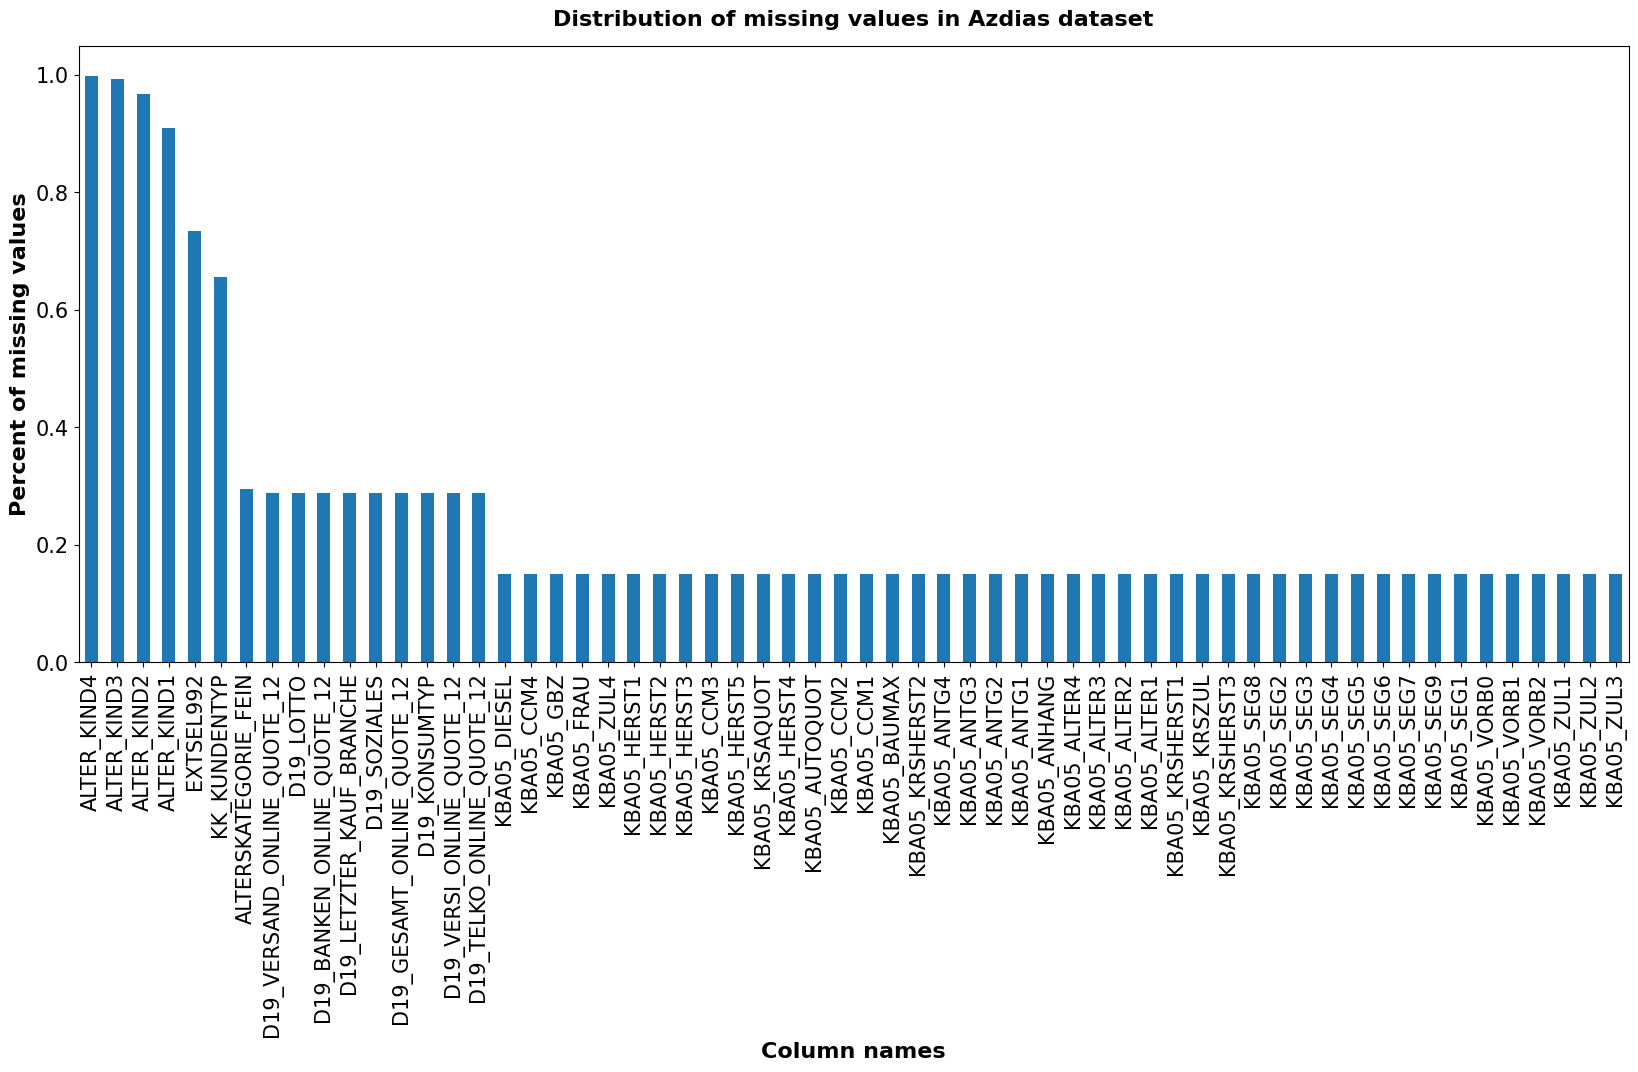

In [14]:
# Here we plot just to visualise the different features and their respective percentage of missing values

azdias_null_percentage.sort_values(ascending = False)[:60].plot(kind = 'bar', figsize = (20,8), fontsize = 15)
plt.title("Distribution of missing values in Azdias dataset", fontsize = 16, fontweight = "bold", y = 1.02)
plt.xlabel("Column names",fontsize = 16, fontweight = 'bold')
plt.ylabel("Percent of missing values", fontsize = 16, fontweight = 'bold');

In [15]:
# Any features with >= 15% missing values, will be dropped.

azdias_col_to_drop = azdias_null_percentage[azdias_null_percentage.sort_values(ascending = False).round(2) >= .15]
len(list(azdias_col_to_drop.index))

80

In [16]:
azdias = azdias.drop(columns = list(azdias_col_to_drop.index))
azdias.shape

(891221, 286)

In [17]:
# We'll look at missing data / Null values at row level
row_has_null = azdias.isnull().any(axis=1)

# Display rows with null values
rows_with_null = azdias[row_has_null]
rows_with_null.shape

(181500, 286)

In [18]:
missing_percentage = (azdias.isnull().sum(axis=1) / len(azdias.columns)) * 100

# Filter rows with >= 15% missing values

rows_with_high_missing = azdias[missing_percentage >= 15]
rows_with_high_missing.index

Int64Index([     0,     11,     14,     15,     17,     20,     23,     24,
                26,     30,
            ...
            891154, 891159, 891164, 891170, 891171, 891172, 891173, 891175,
            891185, 891187],
           dtype='int64', length=105800)

In [19]:
azdias = azdias.drop(index = rows_with_high_missing.index, axis = 0)
azdias.shape

(785421, 286)

In [20]:
# Checking columns with categorical values
azdias.select_dtypes('object').head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8.0,51.0,1992-02-10 00:00:00,W
2,4C,4.0,24.0,1992-02-12 00:00:00,W
3,2A,2.0,12.0,1997-04-21 00:00:00,W
4,6B,6.0,43.0,1992-02-12 00:00:00,W
5,8C,8.0,54.0,1992-02-12 00:00:00,W


In [21]:
print(azdias['OST_WEST_KZ'].value_counts())

# Converting to 0's and 1's since it won't be creating additional columns / features
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].apply(lambda x: 0 if x == 'W' else 1)

W    619287
O    166134
Name: OST_WEST_KZ, dtype: int64


In [22]:
azdias['OST_WEST_KZ'].value_counts()

0    619287
1    166134
Name: OST_WEST_KZ, dtype: int64

In [23]:
list(azdias.select_dtypes('object').columns)

['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'EINGEFUEGT_AM']

In [24]:
# For the remainder of the multi-level categorical features, we will drop them
# if we convert them into a one-hot encoding, we'll be adding back 10's of columns & increasing dimensionality
# We'll create a function here that'll do that for us, and we can use later on for our Customer df

def category_deleter(df):
    
    """ 
    This function serves to remove categorical features from a data
    Input: df
    Output: Numerical Dataframe only
    
    """
    col_index = df.select_dtypes('object').columns.values
    df = df.drop(columns = list(df.select_dtypes('object').columns), inplace = True)
    
    return df
    

In [25]:
# Using our function and checking the result (shape)
category_deleter(azdias)

In [26]:
# We now have a dataframe with 282 columns and no column with more than 4% missing values
# getting the feature names with missing values

col_remaining = list(azdias.isnull().sum()[(azdias.isnull().sum() \
                                       .sort_values(ascending = False) / len(azdias))*100 > 0].index)
col_remaining

['ANZ_HH_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'EWDICHTE',
 'FIRMENDICHTE',
 'GEBAEUDETYP_RASTER',
 'GEMEINDETYP',
 'GFK_URLAUBERTYP',
 'HH_DELTA_FLAG',
 'INNENSTADT',
 'KKK',
 'KONSUMNAEHE',
 'KONSUMZELLE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'ONLINE_AFFINITAET',
 'ORTSGR_KLS9',
 'PLZ8_ANTG1',
 'PLZ8_ANTG2',
 'PLZ8_ANTG3',
 'PLZ8_ANTG4',
 'PLZ8_BAUMAX',
 'PLZ8_GBZ',
 'PLZ8_HHZ',
 'REGIOTYP',
 'RELAT_AB',
 'RETOURTYP_BK_S',
 'RT_KEIN_ANREIZ',
 'RT_SCHNAEPPCHEN',
 'RT_UEBERGROESSE',
 'STRUKTURTYP',
 'UMFELD_ALT',
 'UMFELD_JUNG',
 'VERDICHTUNGSRAUM',
 'VHN',
 'VK_DHT4A',
 'VK_DISTANZ',
 'VK_ZG11',
 'W_KEIT_KIND_HH']

In [27]:
for i in col_remaining:
    azdias[i].fillna(azdias[i].median(), inplace=True)


In [28]:
# We need to impute those missing values
# We'll use the 'Median' instead of mean, as it is wiser to use when you don't have a normally distributed set
# Let's create a function that'll assist us in doing that, and will be useful later

def median_imputer(df):
    """
    This function fills the missing values in a dataset 
    with each columns respective median value
    Input: df
    Output: the missing / NaN values for each feature with 
            its respective features median value
            
    """
    col_remaining = list(df.isnull().sum()[(df.isnull().sum() \
                    .sort_values(ascending = False) / len(azdias))*100 > 0].index)
    col_remaining
    for i in col_remaining:
        df[i].fillna(df[i].median(), inplace=True)
    
    return df

In [29]:
median_imputer(azdias)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,-1,9.0,0.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,4.0,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
5,910244,3,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
891216,825761,-1,5.0,17.0,15.0,0.0,0.0,1.0,11.0,0.0,...,2.0,4.0,7.0,8.0,3.0,4.0,3.0,4,2,3
891217,825771,-1,9.0,16.0,11.0,0.0,0.0,1.0,11.0,0.0,...,4.0,6.0,9.0,6.0,6.0,9.0,5.0,6,1,2
891218,825772,-1,1.0,17.0,3.0,0.0,0.0,0.0,3.0,0.0,...,2.0,7.0,10.0,8.0,4.0,5.0,7.0,4,2,2
891219,825776,-1,9.0,0.0,7.0,0.0,1.0,1.0,5.0,0.0,...,4.0,9.0,8.0,5.0,1.0,9.0,5.0,5,1,1


In [30]:
azdias.isnull().sum().sort_values(ascending = False) / len(azdias)

LNR                     0.0
KBA13_KW_90             0.0
KBA13_PEUGEOT           0.0
KBA13_OPEL              0.0
KBA13_NISSAN            0.0
                       ... 
KBA05_HERSTTEMP         0.0
KBA05_MODTEMP           0.0
KBA13_ALTERHALTER_30    0.0
KBA13_ALTERHALTER_45    0.0
ALTERSKATEGORIE_GROB    0.0
Length: 282, dtype: float64

In [31]:
# Next, we'll create a function that scales our dataset
# Some benefits of scaling features :
    #1. Scaling equates the importance of features in a dataset
    #2. Helps certain algorithms that rely on distance-based pattern identification
    #3. Is a step towards preparing your data for PCA (dimensionality reduction) and K-Means clustering

def standard_scaler(df):
    
    """
    This function applies standard scaling to a dataset,
    essentially transforming all numerical features to a 
    standard normal distribution. It checks for non-numerical
    features and provides an error message if found.

    Input: the DataFrame to be transformed
    Output: a scaled DataFrame

    """
    non_numeric_columns = [x for x in df.dtypes.values if x not in ['int64', 'float64']]
    if non_numeric_columns:
        print("Columns with non-numerical features:", non_numeric_columns)
        return None
    
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    # Convert the scaled array back to a DataFrame
    scaled_df = pd.DataFrame(scaled_data, columns = df.columns)
    
    return scaled_df


In [32]:
azdias = standard_scaler(azdias)
azdias

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.061029,-0.568257,1.262897,-1.429778,0.174632,-0.126536,-0.307147,0.230034,0.310467,-0.060395,...,1.388932,0.703509,1.071122,1.467329,-0.546409,0.560431,-0.029335,1.150069,0.957654,-1.682046
1,1.061049,-0.568257,1.262897,0.799389,0.110219,-0.126536,-0.307147,-0.632275,-0.041771,-0.060395,...,-0.350510,1.053897,0.455422,0.023896,-0.546409,0.560431,-1.059379,1.150069,0.957654,0.168515
2,1.061053,1.865214,-0.935791,0.274879,-0.469495,-0.126536,-0.307147,-1.494583,-0.394009,-0.060395,...,-2.089952,0.353121,0.763272,1.828187,-0.010003,0.560431,1.515732,-0.270859,0.957654,1.093795
3,1.061111,-0.568257,-0.935791,1.192771,-0.340669,-0.126536,-0.307147,1.954651,-0.323561,-0.060395,...,-0.350510,-1.048432,-0.775978,-0.697820,-1.082815,0.560431,-0.544357,0.439605,-1.044219,0.168515
4,1.061123,2.676371,-0.935791,-0.118503,-0.211844,-0.126536,-0.307147,-0.632275,-0.394009,-0.060395,...,-0.350510,1.404286,-0.160278,-0.697820,1.062810,0.560431,1.515732,0.439605,0.957654,-1.682046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785416,0.732819,-0.568257,0.163553,0.799389,0.432283,-0.126536,-0.307147,-0.632275,0.240020,-0.060395,...,-0.350510,-0.698043,-0.160278,0.745613,-0.546409,-2.068676,-0.544357,0.439605,0.957654,0.168515
785417,0.732858,-0.568257,1.262897,0.668261,0.174632,-0.126536,-0.307147,-0.632275,0.240020,-0.060395,...,1.388932,0.002733,0.455422,0.023896,1.062810,0.560431,0.485688,1.860534,-1.044219,-0.756766
785418,0.732862,-0.568257,-0.935791,0.799389,-0.340669,-0.126536,-0.307147,-1.494583,-0.323561,-0.060395,...,-0.350510,0.353121,0.763272,0.745613,-0.010003,-1.542854,1.515732,0.439605,0.957654,-0.756766
785419,0.732877,-0.568257,1.262897,-1.429778,-0.083019,-0.126536,1.678317,-0.632275,-0.182666,-0.060395,...,1.388932,1.053897,0.147572,-0.336962,-1.619221,0.560431,0.485688,1.150069,-1.044219,-1.682046


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

Now that we've cleaned our dataset, we are left with a df with over 280+ features. The problem remains that we have very high dimensional dataset. In turn, this would become computationally expensive, overfitting becomes a more prominent issue, data-density becomes low, and ultimately difficult for an algorithm to find meaningful patterns. 

As such, we'll apply a technique commmonly known as 'Principal Component Analysis' (PCA) that helps reducing what Data Scientists refer to as the 'curse of dimensionality' - meaning, the higher the features (dimensions) of a dataset, the more challenges and issues we potentially face. PCA is essentially an unsupervised algorithm that reduces features whilst attempting to capture as much variance in the data as possible. Essentially, it is a trade-off between keeping all the features vs. reducing them and losing some degree or information (variance) in our data.

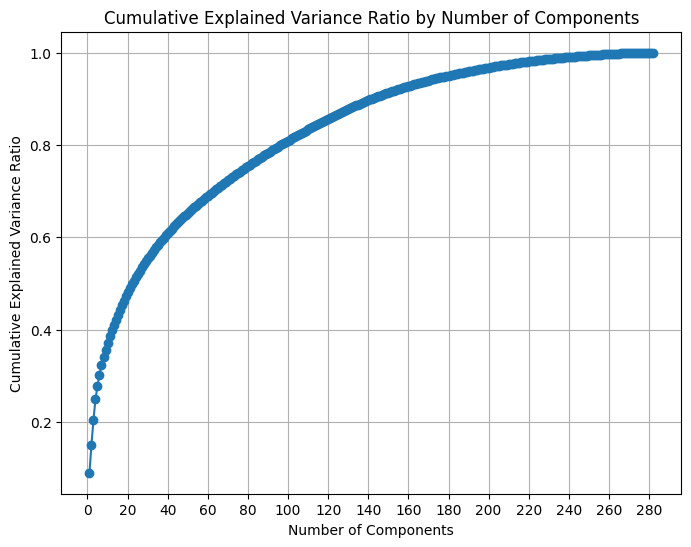

Execution time: 5.989880577723185 minutes


In [33]:
# We'll create a function that will plot the cumulative variance vs. each Principal Component

import time
start_time = time.time()

def pca_graph(df):
    """
    This function applies PCA to a dataset and plots a graph of variance vs. features.
    Input: your dataset (DataFrame)
    Output: a graph that shows the cumulative variance on the y-axis and number of components on the x-axis
    
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA

    pca = PCA(n_components=df.shape[1])  # Use the same number of components as original features
    pca.fit(df)

    # Get the cumulative explained variance ratio for all components
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

    # Plot the cumulative explained variance ratio
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio by Number of Components')
    plt.xticks(np.arange(0, len(cumulative_variance_ratio) + 1, 20))
    plt.grid()
    plt.show()

pca_graph(azdias)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", (execution_time / 60), "minutes")

### We get some very powerful insights here:

    1. We can clearly see the diminishing variance returns with each Principal Component. 
       This goes in line with how PCA fundemantals work
    
    2. Looking at the graph above, we can clearly see that we can reduce our features to 180 and still
       retain approximately 95% of the information (variance) in our data

In [34]:
import pandas as pd
from sklearn.decomposition import PCA

def pca_on_df(df, n=180):
    """
    This function will apply PCA on a given SCALED dataset (df)
    Input: the df to which the PCA will be applied
    Output: returns a df after the PCA transformation
    
    """
    pca = PCA(n_components=n)
    df_pca = pca.fit_transform(df)
    
    # Create a new df with the transformed data 
    df_pca = pd.DataFrame(df_pca, columns=[f'PC_{i}' for i in range(1, n+1)])
    return df_pca, pca


In [35]:
azdias_pca, pca_model = pca_on_df(azdias)
azdias_pca

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_171,PC_172,PC_173,PC_174,PC_175,PC_176,PC_177,PC_178,PC_179,PC_180
0,-3.701614,2.858066,3.363633,-5.623156,1.133905,-2.320921,-0.558231,0.361899,-1.105682,-0.894590,...,1.998619,0.262288,0.186603,-0.195093,0.242084,-1.083677,-0.261009,0.398995,-0.037742,0.557003
1,-0.093179,-1.207048,4.492948,-3.640940,2.808274,-3.713655,1.957009,-0.669990,-0.716472,-0.723084,...,0.477660,0.337110,0.024133,0.456529,-0.230837,-0.046748,-0.601831,-0.100041,0.255612,0.471576
2,2.746387,-6.351890,1.266369,-2.396404,-0.849508,-0.977450,-2.860384,-2.486590,-0.330026,1.954849,...,0.550215,0.020193,-0.279256,-0.228129,0.370276,0.089465,-0.262692,-0.154070,0.353749,-0.381516
3,6.457136,7.323261,2.267517,6.836972,-2.516701,3.450889,-2.079652,-3.215381,5.301482,1.658974,...,-0.132342,-0.468714,-1.244527,0.100438,-0.736566,0.176613,1.337715,-0.376050,0.689634,-1.325521
4,1.511938,-3.282524,2.265620,-2.745255,0.687558,0.315908,-1.410901,-0.408491,2.748853,-2.443975,...,0.145350,-0.276845,0.436641,-0.509066,-1.313320,-0.028951,-1.011040,0.962970,0.238057,-0.436642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785416,2.653004,4.478452,-3.743550,-1.523083,-0.116523,-4.689900,4.101166,1.814743,1.796006,3.095453,...,-0.113602,0.375664,-0.162284,0.347187,0.220970,0.605040,-0.520365,-0.112070,0.342347,0.080099
785417,-8.372440,1.695047,1.104123,0.695733,0.634870,1.059994,-3.137482,1.959740,0.917984,-2.052916,...,0.314238,0.142353,-0.294268,-0.295440,-0.827239,0.884799,0.916331,-0.203416,-0.768995,-0.627823
785418,3.838405,2.995339,1.080215,-5.756335,0.072880,-2.107866,-2.501937,-0.305006,1.817521,-0.437435,...,0.536361,-0.387946,0.379721,-0.383397,-0.419919,-0.297720,-0.547925,-1.071965,-0.409297,-0.795607
785419,-6.280864,5.133121,-4.763913,-1.417970,-3.739010,3.913865,2.017805,3.477338,-2.206905,-1.112081,...,0.640830,-0.005725,0.057631,-0.625308,-0.208425,-0.500565,-0.306253,0.401702,0.508921,0.724896


In [36]:
# Looking into Principal Component 1 and what features it entails
loadings_pc1 = pca_model.components_[0]

# Get the names of the original features

feature_names = azdias.columns
loadings_df = pd.DataFrame({'Feature': feature_names, 'Loading': loadings_pc1})

loadings_df = loadings_df.reindex(loadings_df['Loading'].abs().sort_values(ascending=False).index)
print("Features contributing the most to PC1:")
print(loadings_df[0:10])# Sort the DataFrame by absolute loading values to see which features contribute the most

Features contributing the most to PC1:
            Feature   Loading
108     KBA13_ANTG3 -0.135999
106     KBA13_ANTG1  0.135551
236      PLZ8_ANTG3 -0.135282
234      PLZ8_ANTG1  0.135221
113    KBA13_BAUMAX -0.131787
109     KBA13_ANTG4 -0.131745
226  LP_STATUS_FEIN  0.129932
238     PLZ8_BAUMAX -0.129805
237      PLZ8_ANTG4 -0.129556
229     MOBI_RASTER  0.128047


In [37]:
# We can now apply a K-means clustering unsupervsied algorithm to try & finds meaningful clusters in our dataset
# We'll record the 'inertia' values for different values of K
# Let's build a function that'll support us with that & can be used later

def elbow_method(df):
    
    """
    This function applies a tries a range 'k' values on a dataset and applies the
    k-means unsupervised algorithm. It saves the inertia values for the different values of k
    and will then plot an 'elbow curve' showing the different inertia values against each value
    of k.
    
    The range of k in this function is 20.
    
    Input: Insert a dataframe with numerical features only
    Output: a plot of inertia vs. different k values (1 to 20)
    
    """
    from sklearn.cluster import KMeans

    inertia_values = []
    k_range = range(1, 15+1)

    # Calculate inertia for each value of k
    for k in k_range:
        k_means = KMeans(n_clusters = k, n_init = 10)
        k_means.fit(df)
        inertia_values.append(k_means.inertia_)

    # Plot the elbow curve
    plt.plot(k_range, inertia_values, marker='o')
    plt.xlabel('Number of Clusters (k)', fontweight = 'bold')
    plt.ylabel('Inertia', fontweight = 'bold')
    plt.title('Elbow Method for Optimal k', fontweight = 'bold')
    plt.show()


In [38]:
# Applying our elbow method on our azdias_pca dataset
# We'll apply the elbow method on a random subset of our azdias_pca dataset, as the dataset is massive

azdias_pca_100000 = azdias_pca.sample(100000)
azdias_pca_100000

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_171,PC_172,PC_173,PC_174,PC_175,PC_176,PC_177,PC_178,PC_179,PC_180
494245,9.023164,1.521202,-1.071863,0.193664,-2.349894,-1.962217,-3.948663,3.540815,-1.687062,-2.131461,...,0.205692,-0.255632,0.447903,0.445158,-0.585505,0.391609,-0.183198,0.266421,0.111230,0.562492
490474,0.832600,0.917776,1.028120,-6.783776,4.053862,-2.786416,2.107636,0.521388,-3.243648,3.003556,...,-0.074073,-0.305706,0.163093,1.098714,-0.328120,0.599036,0.294870,-0.039098,-0.365095,-0.423192
225523,-2.553135,0.502373,-4.466609,-6.197339,4.657441,-3.057432,-0.476433,-2.770065,0.017288,-0.702536,...,1.089868,-0.057467,-0.446362,-0.298758,-0.331916,-0.604733,0.059975,1.060078,-0.616817,-0.331979
541251,9.165239,-1.060964,-3.747887,-2.643906,0.803432,-4.084597,0.732990,4.199033,-4.016647,1.143289,...,-0.094298,-0.134331,0.746858,-0.439699,0.079492,-0.349249,-0.581251,-0.089012,0.606558,0.018496
526735,8.019127,1.839114,-1.899059,-2.598135,-0.883005,-2.649728,-2.805258,2.941076,-0.465682,1.148302,...,0.470315,-0.966722,-0.184381,-0.447802,-0.010733,0.240468,-0.103349,-0.087484,1.053504,-0.362008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760101,5.407286,1.293704,0.648563,0.276821,1.057813,-2.589522,-0.605032,1.346046,-3.812836,-1.508113,...,0.122920,-0.310993,0.944922,0.627387,-0.161949,0.111091,0.199966,-0.588229,0.320275,-0.214168
383288,-3.282566,-5.591567,-0.571104,2.316132,1.087282,1.333132,2.859339,0.333717,1.747424,-1.463055,...,-0.574439,0.296748,-1.175669,0.389885,0.097694,-0.036061,0.982930,-0.149644,-0.450809,0.248606
734372,-4.196839,-2.939521,-1.904574,4.201001,2.640476,1.841239,-0.680178,1.378990,-2.126390,-2.634143,...,0.075523,0.716649,-0.145795,-0.943712,-0.764893,-0.292452,-0.169221,0.147896,0.736891,-0.145638
706747,-4.772512,5.329687,-0.666764,-2.270418,0.082176,-2.097498,3.315117,-1.276929,0.150880,-0.920289,...,0.550553,-0.245402,-0.430422,0.327361,0.686513,0.026776,-0.210316,0.519393,0.607184,0.424136


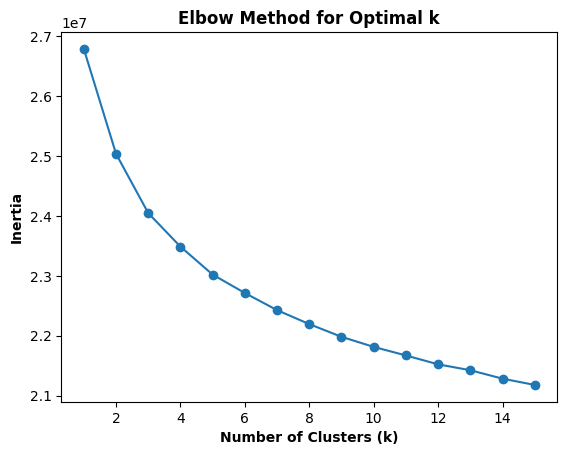

Execution time:  7.6904299338658655 minutes


In [39]:
# Calling our function elbow_method()
# Applying our elbow method on our random subset (100K) of the azdias_pca dataset
# Whilst there is a prominent / clear 'elbow', we'll take K=10

start = time.time()

elbow_method(azdias_pca_100000)

end = time.time()
time_taken = end - start
print('Execution time: ', (time_taken / 60), 'minutes')

In [40]:
# We'll create a function to apply k-means to a dataset

def k_means_algorithm(df, k = 10):
    
    """
    This function comes in handy once you've found the ideal value of k from the function elbow_method.
    Here, it'll apply the k-means algorithm to a dataset with a default k value of 10. This can be changed
    as per your specific needs.
    
    Input: Insert a dataframe with numerical features only
    Output: The dataset with an additional column 'Cluster' with a number 
            from 1 - 10 assigned to each row 
            
    """
    from sklearn.cluster import KMeans
    
    # Create a KMeans instance with the chosen number of clusters
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(df)

    # Get the cluster assignments for each data point
    cluster_assignments = kmeans.labels_
    azdias_clustered = df.copy()  # Create a copy of the original DataFrame
    azdias_clustered['Cluster'] = cluster_assignments
    
    return azdias_clustered


In [41]:
# Calling our function that will add an additional column: 'Clusters'
azdias_clustered = k_means_algorithm(azdias_pca)
azdias_clustered

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_172,PC_173,PC_174,PC_175,PC_176,PC_177,PC_178,PC_179,PC_180,Cluster
0,-3.701614,2.858066,3.363633,-5.623156,1.133905,-2.320921,-0.558231,0.361899,-1.105682,-0.894590,...,0.262288,0.186603,-0.195093,0.242084,-1.083677,-0.261009,0.398995,-0.037742,0.557003,3
1,-0.093179,-1.207048,4.492948,-3.640940,2.808274,-3.713655,1.957009,-0.669990,-0.716472,-0.723084,...,0.337110,0.024133,0.456529,-0.230837,-0.046748,-0.601831,-0.100041,0.255612,0.471576,3
2,2.746387,-6.351890,1.266369,-2.396404,-0.849508,-0.977450,-2.860384,-2.486590,-0.330026,1.954849,...,0.020193,-0.279256,-0.228129,0.370276,0.089465,-0.262692,-0.154070,0.353749,-0.381516,5
3,6.457136,7.323261,2.267517,6.836972,-2.516701,3.450889,-2.079652,-3.215381,5.301482,1.658974,...,-0.468714,-1.244527,0.100438,-0.736566,0.176613,1.337715,-0.376050,0.689634,-1.325521,4
4,1.511938,-3.282524,2.265620,-2.745255,0.687558,0.315908,-1.410901,-0.408491,2.748853,-2.443975,...,-0.276845,0.436641,-0.509066,-1.313320,-0.028951,-1.011040,0.962970,0.238057,-0.436642,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785416,2.653004,4.478452,-3.743550,-1.523083,-0.116523,-4.689900,4.101166,1.814743,1.796006,3.095453,...,0.375664,-0.162284,0.347187,0.220970,0.605040,-0.520365,-0.112070,0.342347,0.080099,4
785417,-8.372440,1.695047,1.104123,0.695733,0.634870,1.059994,-3.137482,1.959740,0.917984,-2.052916,...,0.142353,-0.294268,-0.295440,-0.827239,0.884799,0.916331,-0.203416,-0.768995,-0.627823,1
785418,3.838405,2.995339,1.080215,-5.756335,0.072880,-2.107866,-2.501937,-0.305006,1.817521,-0.437435,...,-0.387946,0.379721,-0.383397,-0.419919,-0.297720,-0.547925,-1.071965,-0.409297,-0.795607,3
785419,-6.280864,5.133121,-4.763913,-1.417970,-3.739010,3.913865,2.017805,3.477338,-2.206905,-1.112081,...,-0.005725,0.057631,-0.625308,-0.208425,-0.500565,-0.306253,0.401702,0.508921,0.724896,1


In [42]:
azdias_clustered['Cluster'].value_counts()

3    112496
5    105445
2     95352
0     83144
7     81735
1     79775
4     62859
6     60403
9     53018
8     51194
Name: Cluster, dtype: int64

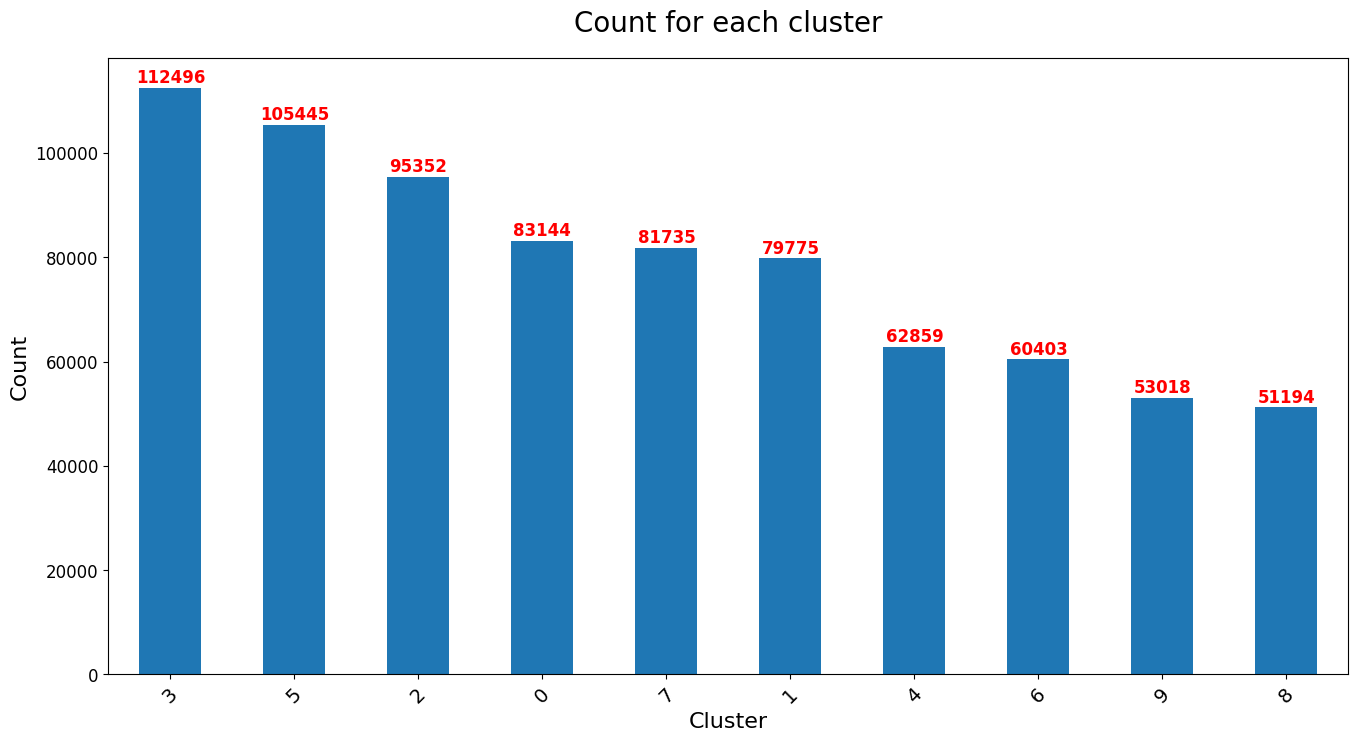

In [43]:
# Plotting the clusters & their values visually

cluster_counts = azdias_clustered['Cluster'].value_counts()
chart = cluster_counts.plot(kind='bar', figsize=(16, 8))

plt.title('Count for each cluster', fontsize=20, y=1.03)
plt.xlabel('Cluster', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize = 14, rotation = 45)
plt.yticks(fontsize = 12)

for i, j in enumerate(cluster_counts):
    chart.text(i, j + 1000, str(j), ha = 'center', fontsize = 12, fontweight = 'bold', color = 'red')
plt.show()


Now that we've pre-processed, cleaned, and applied unsupervised machine learning algorithms on our population data (azdias), we were finally able to divide our population into meaningful & cluster them into meaningful subsets.

We could see there is quite a vast difference in distribution in some of these clusters. For example, cluster number 6 and cluster number 5 differ in double the size.

Ultimately, what we really want to do next is the following on our customers dataset:

1. Any features with >= 15% missing values, will be dropped.
2. Drop rows with >= 15% missing values
3. Binary categorical features will be converted to 0's and 1's
4. Remainder of the multi-level categorical features will be dropped
5. We'll use the 'Median' to impute missing / NaN values
6. Scale the Data using StandardScalar()
7. Apply PCA to reduce dimensionality
8. Apply k-means clustering with k=10 

Last but not least, we can then directly compare the cluster / cluster distribution between the population & the customers database.

In [136]:
customers = pd.read_csv('/Users/basharkhaddage/Desktop/Udacity - Data Science Nanodegree/Project 4 - Capstone Project - Arvato Financial Services/Udacity_CUSTOMERS_052018.csv', sep=';')

/var/folders/f9/yr8f8sks06l5j44pmr6pvfr40000gn/T/ipykernel_751/1471945815.py:1: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('/Users/basharkhaddage/Desktop/Udacity - Data Science Nanodegree/Project 4 - Capstone Project - Arvato Financial Services/Udacity_CUSTOMERS_052018.csv', sep=';')


In [137]:
customers.shape

(191652, 369)

In [138]:
customers_features_to_drop = list(customers.isnull().sum()[customers.isnull().sum() \
                              / len(customers) >= .25].sort_values(ascending = False).index)

In [139]:
# Any features with >= 25% missing values, will be dropped
customers = customers.drop(columns = customers_features_to_drop)

In [140]:
customers

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,0.0,2.0,0.0,5.0,4.0,1.0,...,5.0,3.0,2.0,9.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,0.0,3.0,0.0,NaN,NaN,NaN,...,6.0,6.0,3.0,9.0,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,0.0,1.0,0.0,2.0,5.0,2.0,...,10.0,13.0,11.0,9.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,0.0,0.0,0.0,2.0,5.0,1.0,...,6.0,4.0,2.0,9.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,0.0,4.0,0.0,6.0,4.0,3.0,...,3.0,5.0,4.0,9.0,1,FOOD,MULTI_BUYER,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,154561,1,1.0,9.0,0.0,1.0,0.0,4.0,5.0,1.0,...,8.0,8.0,5.0,9.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,3
191648,154563,-1,2.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0,...,10.0,7.0,4.0,9.0,3,COSMETIC,SINGLE_BUYER,0,2,4
191649,148813,2,1.0,15.0,0.0,3.0,0.0,2.0,5.0,1.0,...,8.0,8.0,5.0,9.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
191650,148852,3,1.0,13.0,0.0,4.0,0.0,4.0,1.0,3.0,...,1.0,1.0,1.0,9.0,3,FOOD,SINGLE_BUYER,0,2,3


In [141]:
# Drop rows with >= 25% missing values
customers.isnull()[customers.isnull().any(axis=1)]
customers_missing_percentage_row = (customers.isnull().sum(axis=1) / len(customers.columns)) * 100
customers_rows_to_drop = customers[customers_missing_percentage_row > 30.0]
customers_rows_to_drop.index

Int64Index([], dtype='int64')

In [142]:
customers = customers.drop(index =customers_rows_to_drop.index)
customers.shape

(191652, 141)

In [143]:
# Binary categorical features will be converted to 0's and 1's
# or if 0 / 1 / 2 can be created

customers.select_dtypes('object').columns

Index(['D19_LETZTER_KAUF_BRANCHE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP'], dtype='object')

In [144]:
customers['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [145]:
customers['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [146]:
customers['CUSTOMER_GROUP'] = customers['CUSTOMER_GROUP'] \
                            .apply(lambda x: 0 if x == 'MULTI_BUYER' else 1)

In [147]:
customers['PRODUCT_GROUP'] = customers['PRODUCT_GROUP'] \
                            .apply(lambda x: 0 if x == 'COSMETIC_AND_FOOD' else(1 if x == 'FOOD' else 2))

In [148]:
# Calling our function category_deleter()
category_deleter(customers)

In [149]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 140 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(44), int64(96)
memory usage: 204.7 MB


In [150]:
# We'll use the 'Median' to impute missing / NaN values
# Calling our function median_imputer()

median_imputer(customers)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,0.0,2.0,0.0,5.0,4.0,1.0,...,5.0,3.0,2.0,9.0,3,0,0,0,1,4
1,9628,-1,9.0,11.0,0.0,3.0,0.0,4.0,5.0,2.0,...,6.0,6.0,3.0,9.0,3,1,1,0,1,4
2,143872,-1,1.0,6.0,0.0,1.0,0.0,2.0,5.0,2.0,...,10.0,13.0,11.0,9.0,3,0,0,0,2,4
3,143873,1,1.0,8.0,0.0,0.0,0.0,2.0,5.0,1.0,...,6.0,4.0,2.0,9.0,1,2,0,0,1,4
4,143874,-1,1.0,20.0,0.0,4.0,0.0,6.0,4.0,3.0,...,3.0,5.0,4.0,9.0,1,1,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,154561,1,1.0,9.0,0.0,1.0,0.0,4.0,5.0,1.0,...,8.0,8.0,5.0,9.0,3,0,0,0,1,3
191648,154563,-1,2.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0,...,10.0,7.0,4.0,9.0,3,2,1,0,2,4
191649,148813,2,1.0,15.0,0.0,3.0,0.0,2.0,5.0,1.0,...,8.0,8.0,5.0,9.0,3,0,0,0,1,4
191650,148852,3,1.0,13.0,0.0,4.0,0.0,4.0,1.0,3.0,...,1.0,1.0,1.0,9.0,3,1,1,0,2,3


In [151]:
# Scale the Data using StandardScalar()
# Calling our function standard_scaler()

standard_scaler(customers)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1.558070,1.189681,-0.325074,-0.231893,-0.238379,-0.166805,-0.116283,0.73182,-0.019325,-1.077655,...,0.283323,-0.566641,-0.581986,0.263604,0.362174,-0.860037,-0.670295,-0.314959,-0.776965,0.864527
1,-1.558034,-0.966005,4.271391,-0.048785,-0.238379,0.656067,-0.116283,0.17601,0.708888,-0.426223,...,0.677318,0.627377,-0.065440,0.263604,0.362174,0.368170,1.491879,-0.314959,-0.776965,0.864527
2,0.868420,-0.966005,-0.325074,-0.964328,-0.238379,-0.989677,-0.116283,-0.93561,0.708888,-0.426223,...,2.253295,3.413419,4.066924,0.263604,0.362174,-0.860037,-0.670295,-0.314959,1.287059,0.864527
3,0.868438,0.471119,-0.325074,-0.598111,-0.238379,-1.812549,-0.116283,-0.93561,0.708888,-1.077655,...,0.677318,-0.168635,-0.581986,0.263604,-1.349447,1.596377,-0.670295,-0.314959,-0.776965,0.864527
4,0.868456,-0.966005,-0.325074,1.599192,-0.238379,1.478939,-0.116283,1.28763,-0.019325,0.225210,...,-0.504665,0.229371,0.451105,0.263604,-1.349447,0.368170,-0.670295,-0.314959,-0.776965,-0.056071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,1.061624,0.471119,-0.325074,-0.415002,-0.238379,-0.989677,-0.116283,0.17601,0.708888,-1.077655,...,1.465306,1.423389,0.967651,0.263604,0.362174,-0.860037,-0.670295,-0.314959,-0.776965,-0.056071
191648,1.061660,-0.966005,0.249484,-2.062979,-0.238379,-1.812549,-0.116283,-0.93561,0.708888,-0.426223,...,2.253295,1.025383,0.451105,0.263604,0.362174,1.596377,1.491879,-0.314959,1.287059,0.864527
191649,0.957729,1.189681,-0.325074,0.683650,-0.238379,0.656067,-0.116283,-0.93561,0.708888,-1.077655,...,1.465306,1.423389,0.967651,0.263604,0.362174,-0.860037,-0.670295,-0.314959,-0.776965,0.864527
191650,0.958434,1.908243,-0.325074,0.317432,-0.238379,1.478939,-0.116283,0.17601,-2.203964,0.225210,...,-1.292654,-1.362653,-1.098531,0.263604,0.362174,0.368170,1.491879,-0.314959,1.287059,-0.056071


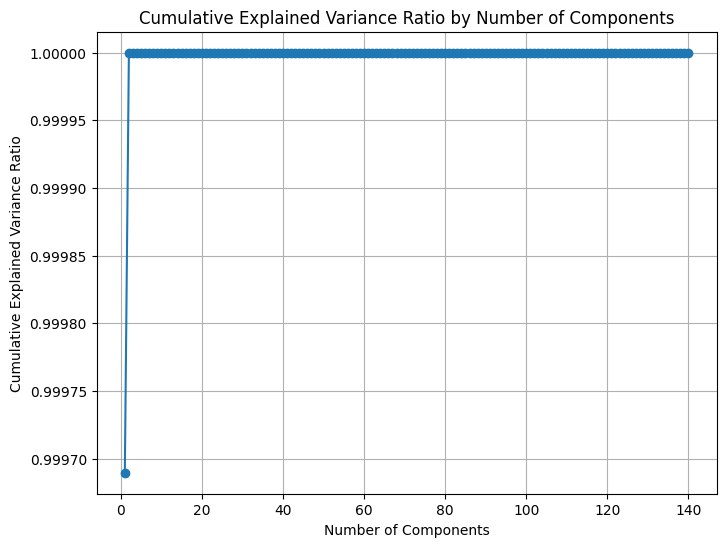

In [152]:
# plot a PCA graph for customers dataset
# Calling our function pca_graph()

pca_graph(customers)

In [153]:
customer_with_cluster = k_means_algorithm(customers)
customer_with_cluster

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ANZ_KINDER,ANZ_PERSONEN,ANZ_TITEL,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,...,VK_DISTANZ,VK_ZG11,WOHNDAUER_2008,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB,Cluster
0,9626,2,1.0,10.0,0.0,2.0,0.0,5.0,4.0,1.0,...,3.0,2.0,9.0,3,0,0,0,1,4,3
1,9628,-1,9.0,11.0,0.0,3.0,0.0,4.0,5.0,2.0,...,6.0,3.0,9.0,3,1,1,0,1,4,3
2,143872,-1,1.0,6.0,0.0,1.0,0.0,2.0,5.0,2.0,...,13.0,11.0,9.0,3,0,0,0,2,4,2
3,143873,1,1.0,8.0,0.0,0.0,0.0,2.0,5.0,1.0,...,4.0,2.0,9.0,1,2,0,0,1,4,2
4,143874,-1,1.0,20.0,0.0,4.0,0.0,6.0,4.0,3.0,...,5.0,4.0,9.0,1,1,0,0,1,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191647,154561,1,1.0,9.0,0.0,1.0,0.0,4.0,5.0,1.0,...,8.0,5.0,9.0,3,0,0,0,1,3,5
191648,154563,-1,2.0,0.0,0.0,0.0,0.0,2.0,5.0,2.0,...,7.0,4.0,9.0,3,2,1,0,2,4,5
191649,148813,2,1.0,15.0,0.0,3.0,0.0,2.0,5.0,1.0,...,8.0,5.0,9.0,3,0,0,0,1,4,2
191650,148852,3,1.0,13.0,0.0,4.0,0.0,4.0,1.0,3.0,...,1.0,1.0,9.0,3,1,1,0,2,3,2


In [154]:
customer_with_cluster['Cluster'].value_counts()

0    19413
5    19389
2    19342
8    19278
4    19203
9    19127
1    19051
7    18987
6    18943
3    18919
Name: Cluster, dtype: int64

In [19]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [20]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

FileNotFoundError: [Errno 2] No such file or directory: '../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv'

In [ ]:
mailout_train.head()

In [ ]:
customers.head()